# <center> STOCK PRICE DEEP LEARNING PREDICTION
#### <center> RNN(Recurrent Neural Network) - LSTM(Long Short Term Memory) -  GRU(Gated Recurrent Unit) </center>
***

# A. Theory - Deep Learning Strategies for Time Series Data

### 1. RNN (Recurrent Neural Network) 


### 2. LTSM (Long Short-Term Memory Networks)

Reference: [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Long Short-Term Memory models are extremely powerful time-series models. 
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They can predict an arbitrary number of steps into the future. An LSTM module (or cell) has 5 essential components which allows it to model both long-term and short-term data.

* Cell state (ct) - This represents the internal memory of the cell which stores both short term memory and long-term memories
* Hidden state (ht) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate (it) - Decides how much information from current input flows to the cell state
* Forget gate (ft) - Decides how much information from the current input and the previous cell state flows into the current cell state
* Output gate (ot) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

Try to predict stock price movement, not the exact stock value

![LTSM states](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1523953369/lstm_xszk4d.png)

### 3. GRU (Gated Recurrent Unit) 


# B. Apply Deep Learning Strategies for Stock Price Prediction

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import yfinance
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from scipy import stats
import pandas_ta as ta
import talib
from plot_stock import *
from dateutil.relativedelta import relativedelta

In [2]:
import chart_studio.plotly as py
import plotly.io as pio
import kaleido
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [3]:
import tqdm
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
import seaborn as seabornInstance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.cbook as cbook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tqdm import tqdm_notebook
from sklearn import metrics
from math import sqrt
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.metrics import r2_score
#from sklearn.metrics import val_mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

## I. Data Preprocessing

* Step 1: Load stock price data from yfinance
* Step 2: Split data based on Closing price to Training set and Testing Set (80% - 20%)
* Step 3: Scale data with MinMax Scaler so every points failed in range (0, 1)
* Step 4: Split the training set to every 30 days of training data and validation on the next 1 day 

In [4]:
def draw_candlestick_price(ticker, df, shorter_window, longer_window, is_static=False):
    # Calculate and define moving average of window1 periods
    avg1 = df.Close.rolling(window=shorter_window, min_periods=1).mean()

    # Calculate and define moving average of window2 periods
    avg2 = df.Close.rolling(window=longer_window, min_periods=1).mean()
        
    
    # Construct a 2 x 1 Plotly figure
    fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])
    
    # Add Volume
    fig.add_trace(
        go.Bar(x=df.index, y=df.Volume,
                       name='Volume', opacity=0.8), row=1, col=1, secondary_y=True
    )
    
    # Candlestick chart for pricing
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['Open'],
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            name=ticker,
            increasing_line_color='#ff9900',
            decreasing_line_color='black',
            showlegend=True
        ), row=1, col=1, secondary_y=False,
    )
    
    # Moving Average line chart
    fig.add_trace(
        go.Scatter(x=df.index, y=avg1, name=f'MA{shorter_window}'),secondary_y=False)
    fig.add_trace(
          go.Scatter(x=df.index, y=avg2, name=f'MA{longer_window}'),secondary_y=False)
        
    # Make it pretty
    layout = go.Layout(
        plot_bgcolor='#efefef',
        width=1000,
        height=500,
        # Font Families
        font_family='Monospace',
        font_color='#000000',
        font_size=15,
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        ),
        legend=dict( orientation='h',yanchor='middle', y=1.1, xanchor="left", x=0.5),
        hovermode='x',
        hoverlabel=dict(font=dict(size=10))
    )
    # Update options and show plot
    fig.update_layout(layout)
    if not is_static:
        fig.show()
    else:
        fig.show(renderer="png")

In [34]:
class Stock:
    '''
    Python class to obtain, visualize and analyze stock price of any ticker 
    '''
    # Step 1: Load data
    def __init__(self, ticker, start_date, end_date=datetime.date.today() - relativedelta(days=1)):
        self.ticker = ticker.upper()
        self.start_date = start_date
        self.end_date = end_date
        self.df = yfinance.download(self.ticker, start=self.start_date, end=self.end_date)
        #self.df['Capitalization'] = self.df['Adj Close'] * self.df['Volume']
        
    def draw_price_candlestick(self, window1, window2, is_static=False):
        draw_candlestick_price(self.ticker, self.df, window1, window2, is_static)
        
    # Step 2: Split training and testing dataset
    def split_data(self, training_size):
        training_index = round(self.df.shape[0]*training_size)
        testing_index = round(self.df.shape[0]*training_size) + 1

        self.training = self.df[:training_index].filter(['Close'])
        self.testing = self.df[testing_index:].filter(['Close'])
        print('# Records:', self.df.shape[0])
        print(f'Training Dataset: 0 to {training_index}; {self.training.index}' )
        print(f'Testing Dataset: {testing_index} to {self.df.shape[0]}; {self.testing.index}' )
        
        plt.figure(figsize = (16,6))
        #plt.plot(x,y)
        ax = plt.axes()
        #plt.figure(figsize=(12,7))
        plt.title('Dataset Training & Testing set for Prediction', color= 'BLACK',fontsize = 15,fontweight = "bold")
        plt.xlabel('Date' , fontsize = 18,fontweight = "bold")
        plt.ylabel("Closing Price USD ($)" , fontsize = 10,fontweight = "bold")
        plt.plot(self.training['Close'], 'blue', label='Training Data')
        plt.plot(self.testing['Close'], 'red', label='Testing Data')
        #plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
        plt.legend()
        #return self.training, self.testing
    
      
    # Step 3: Scale data with MinMax Scaler so every points failed in range (0, 1)
    # Step 4: Split the training set to every 30 days of training data and validation on the next 1 day 

    def process_data(self):
        # scale training data
        sc = MinMaxScaler(feature_range=(0,1))
        training_scaled = sc.fit_transform(self.training)

        X_train = []
        y_train = []
        for i in range(30, len(training_scaled)):
            X_train.append(training_scaled[i-30:i, 0])
            y_train.append(training_scaled[i, 0])

        X_train, y_train = np.array(X_train), np.array(y_train)

        self.X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        self.y_train = y_train
        print('X train reshape', self.X_train.shape, '| Y train shape', self.y_train.shape)
        print('Number of Training Sample:', len(self.X_train), '\n')
#         print ('First Training Sample:')
#         print ('Training on:\n', self.X_train[1])
#         print('Predict on:\n', self.y_train[1],'\n')

        # scale testing data
        testing_scaled = sc.fit_transform(self.testing)

        X_test = [] 
        for i in range(30, len(testing_scaled)):
            X_test.append(testing_scaled[i-30:i, 0])  

        X_test = np.array(X_test)
        self.X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        self.y_test = testing.iloc[30:, 0:].values
        print('X test reshape', self.X_test.shape,'| Y test shape', self.y_test.shape)
        
        print('self.y_train:', self.y_train)
        print('self.y_test:', self.y_test)

        #return sc, self.X_train, self.y_train, self.X_test, self.y_test
    
    
    def train_data(self, regressor, epochs=100, batch_size=64):
        # Fitting to the training set
        history = regressor.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size)
        return regressor
        
    def predict(self, model, regressor):
        prediction = regressor.predict(self.X_test)
        prediction = sc.inverse_transform(prediction)
        
        predicted_df = pd.DataFrame()
        predicted_period = testing.tail(self.testing.shape[0]-30).index
        predicted_df['period'] = predicted_period
        predicted_df['Y'] = self.y_test
        predicted_df['prediction'] = prediction
        predicted_df = predicted_df.set_index('period')
        return predicted_df
    
    def plot_model(self, model, predicted_df, is_static=False):
        fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": False}]])
        fig.add_trace(
            go.Scatter(x=predicted_df.index, y= predicted_df.Y, name='Y_true'))
        fig.add_trace(
              go.Scatter(x=predicted_df.index, y= predicted_df.prediction, name='Y_prediction'))

        layout = go.Layout(
        plot_bgcolor='#efefef',
        width=1000,
        height=500,
        # Font Families
        font_family='Monospace',
        font_color='#000000',
        font_size=15,
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        ),
        legend=dict( orientation='h',yanchor='middle', y=1.1, xanchor="left", x=0.5),
        hovermode='x',
        hoverlabel=dict(font=dict(size=10))
        )
        # Update options and show plot
        fig.update_layout(layout)
        if not is_static:
            fig.show()
        else:
            fig.show(renderer="png")

        


[*********************100%***********************]  1 of 1 completed


# Records: 5513
Training Dataset: 0 to 4410; DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2017-06-29', '2017-06-30', '2017-07-03', '2017-07-05',
               '2017-07-06', '2017-07-07', '2017-07-10', '2017-07-11',
               '2017-07-12', '2017-07-13'],
              dtype='datetime64[ns]', name='Date', length=4410, freq=None)
Testing Dataset: 4411 to 5513; DatetimeIndex(['2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-24', '2017-07-25', '2017-07-26',
               '2017-07-27', '2017-07-28',
               ...
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-26', '2021-11-29'],
              dtype='datetime64[ns]', name='Date', length=1102, freq=

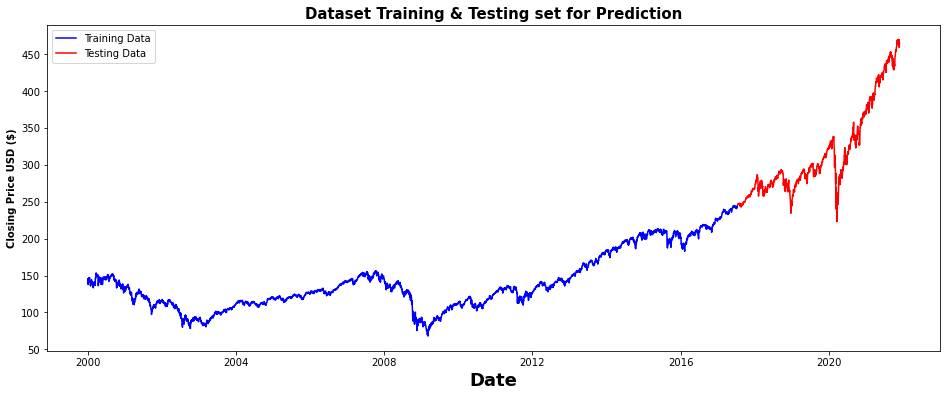

In [35]:
# Get 20 year from yesterday
#start_date = datetime.date.today() - relativedelta(days=1) - relativedelta(years=20) 
start_date = datetime.datetime(2000,1,1)

# Load data
ticker = 'spy'
stock = Stock(ticker, start_date)
stock.draw_price_candlestick(50, 200)

# Split data
stock.split_data(0.8)

# Process data
stock.process_data()

In [37]:
print(stock.X_train[0])

[[0.43799206]
 [0.40577739]
 [0.40719342]
 [0.39444915]
 [0.4397621 ]
 [0.44259415]
 [0.43268195]
 [0.42453978]
 [0.43551401]
 [0.44666524]
 [0.4401161 ]
 [0.44684224]
 [0.43409798]
 [0.43232794]
 [0.40914046]
 [0.41816765]
 [0.41179551]
 [0.40860945]
 [0.38382893]
 [0.40471537]
 [0.41250353]
 [0.41321154]
 [0.42524779]
 [0.42188472]
 [0.4206457 ]
 [0.43161993]
 [0.41445057]
 [0.4160436 ]
 [0.39975926]
 [0.40436136]]


In [38]:
stock.y_train

array([0.41330005, 0.4015293 , 0.39745822, ..., 0.98600962, 0.99631827,
       0.99864058])

## II. Data Modelling

### 1. Recurrent Neural Network (RNN) model

In [40]:
regressorRNN = Sequential()
regressorRNN.add(SimpleRNN(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorRNN.add(Dropout(0.2))
regressorRNN.add(SimpleRNN(units=256))
regressorRNN.add(Dropout(0.2))
regressorRNN.add(Dense(units=1, activation='relu'))
# Compiling the RNN
regressorRNN.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae','mse'])
regressorRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 30, 64)            4224      
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 256)               82176     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 86,657
Trainable params: 86,657
Non-trainable params: 0
_________________________________________________________________


In [41]:
regressorRNN = stock.train_data(regressorRNN)

Epoch 1/100
69/69 [==============================] - 2s 17ms/step - loss: 0.1312 - mae: 0.2844 - mse: 0.1312
Epoch 2/100
69/69 [==============================] - 1s 17ms/step - loss: 0.0191 - mae: 0.1044 - mse: 0.0191
Epoch 3/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0081 - mae: 0.0679 - mse: 0.0081
Epoch 4/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0059 - mae: 0.0574 - mse: 0.0059
Epoch 5/100
69/69 [==============================] - 1s 17ms/step - loss: 0.0045 - mae: 0.0503 - mse: 0.0045
Epoch 6/100
69/69 [==============================] - 1s 17ms/step - loss: 0.0035 - mae: 0.0437 - mse: 0.0035
Epoch 7/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0030 - mae: 0.0404 - mse: 0.0030
Epoch 8/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0023 - mae: 0.0357 - mse: 0.0023
Epoch 9/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0350 - mse: 0.0023
Epoch 10/100
69/69 

69/69 [==============================] - 1s 15ms/step - loss: 4.0564e-04 - mae: 0.0144 - mse: 4.0564e-04
Epoch 72/100
69/69 [==============================] - 1s 15ms/step - loss: 3.2637e-04 - mae: 0.0128 - mse: 3.2637e-04
Epoch 73/100
69/69 [==============================] - 1s 17ms/step - loss: 3.8218e-04 - mae: 0.0142 - mse: 3.8218e-04
Epoch 74/100
69/69 [==============================] - 1s 17ms/step - loss: 3.6814e-04 - mae: 0.0137 - mse: 3.6814e-04
Epoch 75/100
69/69 [==============================] - 1s 16ms/step - loss: 3.4110e-04 - mae: 0.0133 - mse: 3.4110e-04
Epoch 76/100
69/69 [==============================] - 1s 16ms/step - loss: 3.4498e-04 - mae: 0.0133 - mse: 3.4498e-04
Epoch 77/100
69/69 [==============================] - 1s 15ms/step - loss: 3.2030e-04 - mae: 0.0127 - mse: 3.2030e-04
Epoch 78/100
69/69 [==============================] - 1s 16ms/step - loss: 3.7653e-04 - mae: 0.0140 - mse: 3.7653e-04
Epoch 79/100
69/69 [==============================] - 1s 16ms/step - 

In [42]:
RNN_Stock_Price_Prediction = stock.predict('RNN', regressorRNN)
RNN_Stock_Price_Prediction

,Y,prediction
period,,
2017-08-28,244.570007,244.832062
2017-08-29,244.850006,244.715912
2017-08-30,246.009995,245.367096
2017-08-31,247.490005,246.285675
2017-09-01,247.839996,247.478439
...,...,...
2021-11-22,467.570007,463.728790
2021-11-23,468.190002,462.173645
2021-11-24,469.440002,462.409821


In [43]:
stock.plot_model('RNN', RNN_Stock_Price_Prediction)

### 3. Long Short Term Memory Network (LSTM)

In [44]:
regressorLSTM = Sequential()
regressorLSTM.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=128))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(Dense(units=1))
# Compiling the LSTM
regressorLSTM.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae','mse'])
regressorLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 256)           264192    
                                                                 
 dropout_8 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


In [45]:
regressorLSTM = stock.train_data(regressorLSTM)

Epoch 1/100
69/69 [==============================] - 6s 46ms/step - loss: 0.0077 - mae: 0.0523 - mse: 0.0077
Epoch 2/100
69/69 [==============================] - 3s 47ms/step - loss: 0.0010 - mae: 0.0234 - mse: 0.0010
Epoch 3/100
69/69 [==============================] - 3s 47ms/step - loss: 9.7485e-04 - mae: 0.0229 - mse: 9.7485e-04
Epoch 4/100
69/69 [==============================] - 3s 49ms/step - loss: 8.4798e-04 - mae: 0.0216 - mse: 8.4798e-04
Epoch 5/100
69/69 [==============================] - 3s 49ms/step - loss: 9.3284e-04 - mae: 0.0222 - mse: 9.3284e-04
Epoch 6/100
69/69 [==============================] - 3s 49ms/step - loss: 0.0011 - mae: 0.0242 - mse: 0.0011
Epoch 7/100
69/69 [==============================] - 3s 50ms/step - loss: 8.8061e-04 - mae: 0.0220 - mse: 8.8061e-04
Epoch 8/100
69/69 [==============================] - 4s 54ms/step - loss: 8.7614e-04 - mae: 0.0215 - mse: 8.7614e-04
Epoch 9/100
69/69 [==============================] - 4s 54ms/step - loss: 8.0468e-04 - m

69/69 [==============================] - 5s 66ms/step - loss: 3.0822e-04 - mae: 0.0125 - mse: 3.0822e-04
Epoch 71/100
69/69 [==============================] - 5s 68ms/step - loss: 3.1365e-04 - mae: 0.0125 - mse: 3.1365e-04
Epoch 72/100
69/69 [==============================] - 4s 59ms/step - loss: 3.0198e-04 - mae: 0.0124 - mse: 3.0198e-04
Epoch 73/100
69/69 [==============================] - 4s 54ms/step - loss: 2.9283e-04 - mae: 0.0120 - mse: 2.9283e-04
Epoch 74/100
69/69 [==============================] - 4s 65ms/step - loss: 2.8619e-04 - mae: 0.0120 - mse: 2.8619e-04
Epoch 75/100
69/69 [==============================] - 4s 65ms/step - loss: 3.1453e-04 - mae: 0.0125 - mse: 3.1453e-04
Epoch 76/100
69/69 [==============================] - 5s 71ms/step - loss: 2.8146e-04 - mae: 0.0120 - mse: 2.8146e-04
Epoch 77/100
69/69 [==============================] - 5s 72ms/step - loss: 2.6801e-04 - mae: 0.0117 - mse: 2.6801e-04
Epoch 78/100
69/69 [==============================] - 5s 68ms/step - 

In [46]:
LSTM_Stock_Price_Prediction = stock.predict('LSTM', regressorLSTM)

In [47]:
LSTM_Stock_Price_Prediction

,Y,prediction
period,,
2017-08-28,244.570007,243.068466
2017-08-29,244.850006,243.204071
2017-08-30,246.009995,243.452667
2017-08-31,247.490005,244.312698
2017-09-01,247.839996,245.666870
...,...,...
2021-11-22,467.570007,468.916962
2021-11-23,468.190002,468.098083
2021-11-24,469.440002,468.211639


In [48]:
stock.plot_model('LSTM', LSTM_Stock_Price_Prediction)

### 4. Gated Recurrent Unit (GRU) 

In [ ]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=512, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=1024))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
# Compiling the GRU
regressorGRU.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae','mse'])
regressorGRU.summary()

In [ ]:
regressorGRU = stock.train_data(regressorGRU, epochs=50)

In [ ]:
GRU_Stock_Price_Prediction = stock.predict('GRU', regressorGRU)
GRU_Stock_Price_Prediction

In [ ]:
stock.plot_model('GRU', GRU_Stock_Price_Prediction)

## III. Evaluate Model

When dealing with regression models, it is very unlikely that our model will precisely predict the target variable, because the target variable can take on any real value. However, we would naturally like to understand how far away our predicted values are from the true values, so will we utilize a metric that takes into account the overall deviation (Reference: Machine Learning with Spark - Second Edition) 

**Mean Absolute Error (MAE)**: average of the absolute difference between predicted value and true value. The MAE measures the average magnitude of the errors in a set of forecasts, without considering their direction. The MAE is a linear score which means that all the individual differences are weighted equally in the average.

![MAE](https://wikimedia.org/api/rest_v1/media/math/render/svg/3ef87b78a9af65e308cf4aa9acf6f203efbdeded)


**Mean Square Error (MSE)**: is the sum of the square of the difference between the predicted and actual target variables, divided by the number of data points.

![MSE](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781785889936/files/assets/image_07_002.jpg) 


**Root Mean Square Error (RMSE)**:  is the square root of RMSE which measures the average magnitude of the error. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable. The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude

![RMSE](https://www.gstatic.com/education/formulas2/397133473/en/root_mean_square_deviation.svg)


**R square coefficient**: commonly used in statistics to measure how well the model fits the data, how much variance in the target can be explained by the prediction. 

In [ ]:
models = []
R_squared = [] 
MAE = [] # Mean Absolute Error
MSE = [] # Mean Square Error
RMSE = [] # Root Mean Square Error
last_price = []
last_prediction = []

def evaluate_model(model, y_test, prediction):
    r2 = metrics.r2_score(y_test, prediction)
    mae = metrics.mean_absolute_error(y_test, prediction)
    mse = metrics.mean_squared_error(y_test, prediction)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    last_price.append(y_test[-1][0])
    last_prediction.append(prediction[-1][0])
    
    models.append(model)
    R_squared.append(r2)
    MAE.append(mae)
    MSE.append(mse)
    RMSE.append(rmse)

In [ ]:
evaluate_model('RNN', y_test, RNN_Stock_Price_Prediction)
evaluate_model('LSTM', y_test, LSTM_Stock_Price_Prediction)
evaluate_model('GRU', y_test, GRU_Stock_Price_Prediction)

In [ ]:
def compare_model(models, R_squared, MAE, MSE, RMSE):
    compared_models = pd.DataFrame()
    compared_models['Models'] = models
    compared_models['R_squared'] = R_squared
    compared_models['MAE'] = MAE
    compared_models['MSE'] = MSE
    compared_models['RMSE'] = RMSE
    compared_models['last_price'] = last_price
    compared_models['last_prediction'] = last_prediction
    
    return compared_models
    
compare_model(models, R_squared, MAE, MSE, RMSE)

In [ ]:
testing.tail(1)

# C. Reference

1. [Stock Prediction Using Deep Learning with Long Short Term Memory Networks - Carol Hargreaves, Leran Chen
National University of Singapore](https://www.researchgate.net/publication/347515776_Stock_Prediction_Using_Deep_Learning_with_Long-Short-Term-Memory_Networks)  

2. [Comparative Analysis of Recurrent Neural Networks in Stock Price Prediction for Different Frequency Domains](https://www.mdpi.com/1999-4893/14/8/251) 

2. [Stock Prediction with Long Short Term Memory Networks](https://www.researchgate.net/publication/347515776_Stock_Prediction_Using_Deep_Learning_with_Long-Short-Term-Memory_Networks)

3. [Tutorial for LSTM in Python](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)

4. [LSTM Neural Network for Time Series Prediction - Jakob Aungiers](https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction)

5. [Technical Indicators and GRU/LSTM for Time-Series Prediction](https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b)

6. [Deep Learning in Asset Pricing - Luyang Chen
, Markus Pelger and Jason Zhu](https://economics.yale.edu/sites/default/files/deep_learning_in_asset_pricing.pdf)
